In [193]:
import blip_analysis as ba
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import dask
from daskify import Daskified
from label_axes import label_axes


In [2]:
recs = ba.load_recs()

Respiration peaks found
Found file starts
Found file ends
Respiration trace found
Found sniff spikes
Extracting trial names
Found 1408 trials in trial name file
Respiration peaks found
Found file starts
Found file ends
Respiration trace found
Found sniff spikes
Extracting trial names
Found 4608 trials in trial name file
Respiration peaks found
Found file starts
Found file ends
Respiration trace found
Found sniff spikes
Extracting trial names
Found 4288 trials in trial name file
Respiration peaks found
Found file starts
Found file ends
Respiration trace found
Found sniff spikes
Extracting trial names
Found 1440 trials in trial name file
Respiration peaks found
Found file starts
Found file ends
Respiration trace found
Found sniff spikes
Extracting trial names
Found 5328 trials in trial name file
Respiration peaks found
Found file starts
Found file ends
Respiration trace found
Found sniff spikes
Extracting trial names
Found 5328 trials in trial name file
Respiration peaks found
Found file

In [3]:
gcs = [rec.get_good_clusters() for rec in recs.recordings]
ba.load_usrts()
good_units = ba.get_stable_resp_indexes()
gcs = np.concatenate(gcs)[good_units]


Found odour 1
Found odour 3
Found odour 5


In [4]:
def dask_waveforms(gcs_scattered, unit_index, num_wfs=100):
    wfs = gcs_scattered[unit_index].get_waveforms()
    mean_wfs = wfs.mean(axis=0)
    wf_jump_size = len(wfs)//num_wfs
    select_wfs = wfs[::wf_jump_size]
    return mean_wfs, select_wfs

In [5]:
mean_wfs, select_wfs = dask_waveforms(gcs, 0)

In [6]:
print(mean_wfs.shape, select_wfs.shape)

(90, 32) (101, 90, 32)


In [38]:
np.array(wfs).shape

(48578, 90, 32)

In [5]:
dasked = Daskified(memory='32GB')

In [6]:
dasked.start_cluster()

In [7]:
gcs_scattered = dasked.client.scatter(gcs)

In [8]:
dfs = [dask.delayed(dask_waveforms)(gcs_scattered, i) for i in range(130)]

In [9]:
futures = dasked.client.compute(dfs)
dasked.current_futures = futures


In [30]:
dasked.check_progress()

finished 130


In [29]:

for i in range(130):
    status = dasked.current_futures[i].status
    if status == 'lost':
        print(i)
        # single_future = dasked.client.compute(dask.delayed(dask_waveforms)(gcs_scattered, i))
        # dasked.current_futures[i] = single_future

114


In [56]:
dasked.check_progress()

finished 129
pending 1


In [36]:
dasked.current_futures[75]

<Future: finished, type: builtins.tuple, key: dask_waveforms-79a9e0e0-f298-4620-9bf3-f022f426904a>

In [31]:
res = [i.result() for i in tqdm(dasked.current_futures, leave=False, position=0)]

In [32]:
good_units_rec = np.array([rec for rec in recs.recordings for i in range(len(rec.get_good_clusters()))])[good_units]
good_units_chan_map = np.array([i.channel_map for i in good_units_rec])
good_units_chan_pos = np.array([i.channel_positions for i in good_units_rec])

In [33]:
finished_futures = []
finished_chan_map = []
finished_chan_pos = []
for index, i in enumerate(dasked.current_futures):
    if i.status == 'finished':
        finished_futures.append(i)
        finished_chan_map.append(good_units_chan_map[index])
        finished_chan_pos.append(good_units_chan_pos[index])

In [103]:
print(len(good_units_rec))

145


In [34]:
mean_wfs = np.array([i[0] for i in res])
sample_wfs = np.array([i[1][1:101] for i in res])
print(mean_wfs.shape, sample_wfs.shape)

(130, 90, 32) (130, 100, 90, 32)


In [35]:
np.save('230823_mean_wfs.npy', mean_wfs)
np.save('230823_sample_wfs.npy', sample_wfs)

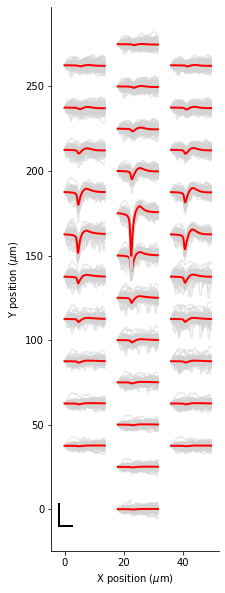

In [190]:
def plot_waveform(ax, mean_wfs, sample_wfs, wf_index,  x_scale=1, y_scale=1, show_single_examps=True, scalebar_pos=[0, 0], color='black'):
    chan_map = good_units_chan_map[wf_index]
    chan_pos = good_units_chan_pos[wf_index]
    for channel_index in range(32):
        chan_loc = np.where(chan_map==channel_index)[0][0]
        x = chan_pos[chan_loc][0]
        y = chan_pos[chan_loc][1]
        xs = np.linspace(x, x+90*x_scale, 90)
        if show_single_examps:
            for i in sample_wfs[wf_index]:
                
                ax.plot(xs, y_scale*i[:, channel_index]+y, color='lightgrey', alpha=0.5)
        ax.plot(xs, y_scale*mean_wfs[wf_index,:, channel_index]+y, color=color, linewidth=2)
    y_bar = np.array([0, 500])/0.195*y_scale + scalebar_pos[1]
    x_bar = np.array([0, 30])*x_scale + scalebar_pos[0]
    ax.plot([scalebar_pos[0], scalebar_pos[0]], y_bar, color='black', linewidth=2)
    ax.plot(x_bar, [y_bar[0], y_bar[0]], color='black', linewidth=2)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_xlabel('X position ($\mu$m)')
    ax.set_ylabel('Y position ($\mu$m)')
fig, ax = plt.subplots(1, 1, figsize=(3, 10))
plot_waveform(ax, mean_wfs, sample_wfs, 43, y_scale=0.005, x_scale=0.15, show_single_examps=True, scalebar_pos=[-2, -10], color='r')

In [109]:
unit = gcs[95]
sts = unit.spike_times

# diffs = []
# for i in tqdm(sts, position=0, leave=False):
#     pre_window = np.int64(i) - 30*100
#     close_spikes = sts[np.where(sts > pre_window)[0]]
#     close_spikes = close_spikes[np.where(close_spikes < i + 30*100)[0]]
#     close_spikes = np.array(close_spikes).astype(np.int64) - i
#     close_spikes = close_spikes[close_spikes != 0]
#     diffs.append(close_spikes)
    

In [88]:
print(np.searchsorted(sts.flatten(), sts.flatten()[23]+1, side='right'))
valid_diffs = sts[24:24] - sts[23]
print(valid_diffs.flatten())

24
[]


In [110]:
diffs = []
for index, i in enumerate(tqdm(sts, position=0, leave=False)):
    last_index = np.searchsorted(sts.flatten(), i+30*100, side='right')[0]
    windowed_values = sts[int(index+1):last_index] - i
    diffs.append(windowed_values.flatten())

198


<BarContainer object of 198 artists>

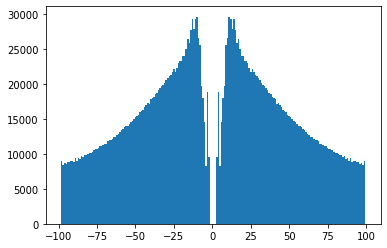

In [133]:
hist, xs = np.histogram(np.concatenate(diffs), bins=np.arange(0, 30*100, 30))
neg_hist = hist[::-1]
hist = np.concatenate([neg_hist, hist])
xs = np.arange(-100, 100, 1)
print(len(hist))
plt.bar(xs[2:], hist, width=1)

In [141]:
def generate_autocorrelogram(unit_index, window=100):
    sts = gcs[unit_index].spike_times
    diffs = []
    for index, i in enumerate(tqdm(sts, position=0, leave=False)):
        last_index = np.searchsorted(sts.flatten(), i+30*window, side='right')[0]
        windowed_values = sts[int(index+1):last_index] - i
        diffs.append(windowed_values.flatten())
    hist, xs = np.histogram(np.concatenate(diffs), bins=np.arange(0, 30*100, 30), density=True)
    neg_hist = hist[::-1]
    hist = np.concatenate([neg_hist, hist])
    xs = np.arange(-100, 100, 1)
    xs = xs[2:]
    return hist, xs

In [139]:
hist_2, xs = generate_autocorrelogram(1, window=100)

<BarContainer object of 198 artists>

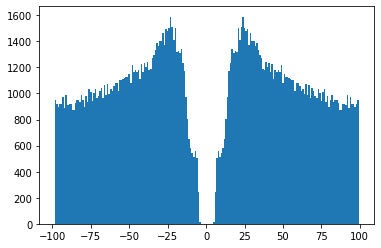

In [136]:
plt.bar(xs, hist_2, width=1)

In [61]:
t1 = sts[:, None].astype(np.int32)
t2 = sts[None, :].astype(np.int32)

In [62]:
diffs = t1 - t2


MemoryError: Unable to allocate 658. GiB for an array with shape (297210, 297210, 1) and data type int64

In [57]:
valid_diffs = diffs[(diffs > -30*100) & (diffs <= 30*100)]
valid_diffs = valid_diffs[valid_diffs != 0]

(array([1.892e+03, 1.820e+03, 1.839e+03, 1.859e+03, 1.896e+03, 1.842e+03,
        1.745e+03, 1.876e+03, 1.888e+03, 1.940e+03, 1.877e+03, 1.967e+03,
        1.954e+03, 2.042e+03, 1.947e+03, 2.059e+03, 2.034e+03, 2.061e+03,
        2.031e+03, 2.077e+03, 2.160e+03, 2.117e+03, 2.219e+03, 2.241e+03,
        2.271e+03, 2.304e+03, 2.348e+03, 2.345e+03, 2.342e+03, 2.399e+03,
        2.441e+03, 2.371e+03, 2.573e+03, 2.719e+03, 2.765e+03, 2.864e+03,
        2.867e+03, 2.983e+03, 3.099e+03, 2.913e+03, 2.646e+03, 2.656e+03,
        2.407e+03, 1.781e+03, 1.235e+03, 1.056e+03, 1.057e+03, 2.590e+02,
        1.000e+00, 2.000e+00, 2.000e+00, 1.000e+00, 2.730e+02, 1.061e+03,
        1.054e+03, 1.251e+03, 1.793e+03, 2.411e+03, 2.663e+03, 2.644e+03,
        2.913e+03, 3.086e+03, 3.001e+03, 2.877e+03, 2.845e+03, 2.762e+03,
        2.721e+03, 2.566e+03, 2.374e+03, 2.439e+03, 2.400e+03, 2.338e+03,
        2.346e+03, 2.334e+03, 2.318e+03, 2.268e+03, 2.239e+03, 2.220e+03,
        2.114e+03, 2.160e+03, 2.074e+0

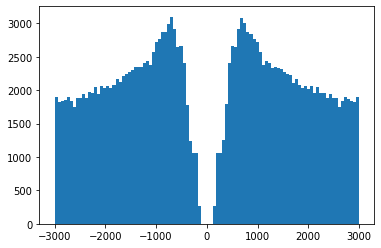

In [59]:
plt.hist(valid_diffs, bins=100)

In [44]:
diffs = np.concatenate(diffs)

(array([1.892e+03, 1.820e+03, 1.839e+03, 1.859e+03, 1.896e+03, 1.842e+03,
        1.745e+03, 1.876e+03, 1.888e+03, 1.940e+03, 1.877e+03, 1.967e+03,
        1.954e+03, 2.042e+03, 1.947e+03, 2.059e+03, 2.034e+03, 2.061e+03,
        2.031e+03, 2.077e+03, 2.160e+03, 2.117e+03, 2.219e+03, 2.241e+03,
        2.271e+03, 2.304e+03, 2.348e+03, 2.345e+03, 2.342e+03, 2.399e+03,
        2.441e+03, 2.371e+03, 2.573e+03, 2.719e+03, 2.765e+03, 2.864e+03,
        2.867e+03, 2.983e+03, 3.099e+03, 2.913e+03, 2.646e+03, 2.656e+03,
        2.407e+03, 1.781e+03, 1.235e+03, 1.056e+03, 1.057e+03, 2.590e+02,
        1.000e+00, 2.000e+00, 2.000e+00, 1.000e+00, 2.590e+02, 1.057e+03,
        1.056e+03, 1.235e+03, 1.781e+03, 2.407e+03, 2.656e+03, 2.646e+03,
        2.913e+03, 3.099e+03, 2.983e+03, 2.867e+03, 2.864e+03, 2.765e+03,
        2.719e+03, 2.573e+03, 2.371e+03, 2.441e+03, 2.399e+03, 2.342e+03,
        2.345e+03, 2.348e+03, 2.304e+03, 2.271e+03, 2.241e+03, 2.219e+03,
        2.117e+03, 2.160e+03, 2.077e+0

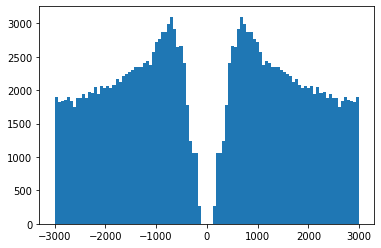

In [45]:
plt.hist(diffs, bins=100)

In [54]:
plt.hist(diffs)

KeyboardInterrupt: 

: 

In [96]:
print(sts.astype())

<class 'numpy.uint64'>


In [87]:
diffs_joined = np.concatenate(diffs)

In [92]:
print(diffs_joined[:50])

[ 511  911 1487  400  976  576  852 1890 2159 2525 2837 1038 1307 1673
 1985 2354  269  635  947 1316 2128  366  678 1047 1859  312  681 1493
  369 1181  812  712 1213 1982 2497 2950  501 1270 1785 2238 2531 2904
  769 1284 1737 2030 2403 2754 2988  515]


In [142]:
hist95, xs = generate_autocorrelogram(95, window=100)
hist39, xs  = generate_autocorrelogram(39, window=100)

In [144]:
def plot_autocorrelogram(ax, hist, xs, color='black'):
    ax.bar(xs, hist, width=1, color=color)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_xlabel('Time (ms)')
    ax.set_ylabel('Probability density of spike')

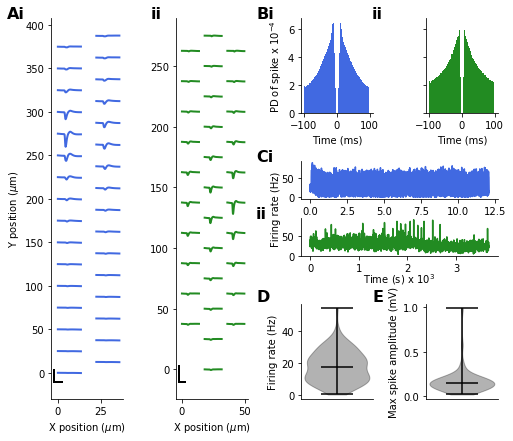

In [203]:
cell_colors = ['royalblue', 'forestgreen']

fig = plt.figure(figsize=(8, 7))
gs = fig.add_gridspec(3, 4, wspace=0.75, hspace=0.5)
wf_ax1 = fig.add_subplot(gs[:, 0])
wf_ax2 = fig.add_subplot(gs[:, 1])
plot_waveform(wf_ax1, mean_wfs, sample_wfs, 95, y_scale=0.005, x_scale=0.15, show_single_examps=False, scalebar_pos=[-2, -10], color=cell_colors[0])
plot_waveform(wf_ax2, mean_wfs, sample_wfs, 39, y_scale=0.005, x_scale=0.15, show_single_examps=False, scalebar_pos=[-2, -10], color=cell_colors[1])
wf_ax2.set_ylabel('')
autocorr_ax1 = fig.add_subplot(gs[0, 2])
autocorr_ax2 = fig.add_subplot(gs[0, 3])
plot_autocorrelogram(autocorr_ax1, hist95, xs, color=cell_colors[0])
plot_autocorrelogram(autocorr_ax2, hist39, xs, color=cell_colors[1])
autocorr_ax2.set_ylabel('')
ylims = [i.get_ylim() for i in [autocorr_ax1, autocorr_ax2]]
ylim = [np.min(ylims), np.max(ylims)]
autocorr_ax1.set_ylim(ylim)
autocorr_ax2.set_ylim(ylim)
autocorr_ax2.set_yticklabels([])
autocorr_ax1.set_yticklabels([0, 2, 4, 6])
autocorr_ax1.set_ylabel('PD of spike x $10^{-4}$')

sub_gs = gs[1, 2:].subgridspec(2, 1, hspace=0.5)
firing_ax1 = fig.add_subplot(sub_gs[0])
firing_ax2 = fig.add_subplot(sub_gs[1])
plot_firing_rate(firing_ax1, gcs, 95, x_scale=0.001, color=cell_colors[0])
plot_firing_rate(firing_ax2, gcs, 39, x_scale=0.001, color=cell_colors[1])
fig_ax = fig.add_subplot(gs[1, 2:], frameon=False)
fig_ax.set_xticks([])
fig_ax.set_yticks([])
fig_ax.set_xlabel('Time (s) x $10^{3}$', labelpad=15)
fig_ax.set_ylabel('Firing rate (Hz)', labelpad=20)

violin_ax1 = fig.add_subplot(gs[2, 3])
violin_ax2 = fig.add_subplot(gs[2, 2])
vps1 = violin_ax1.violinplot(-max_spike_index*0.195/1000, showextrema=True, showmedians=True)
vps2 = violin_ax2.violinplot(avg_frs, showextrema=True, showmedians=True)
violin_ax1.spines['right'].set_visible(False)
violin_ax1.spines['top'].set_visible(False)
violin_ax2.spines['right'].set_visible(False)
violin_ax2.spines['top'].set_visible(False)
violin_ax1.set_ylabel('Max spike amplitude (mV)')
violin_ax2.set_ylabel('Firing rate (Hz)')
violin_ax1.set_xticks([])
violin_ax2.set_xticks([])

color = 'black'
for vps in [vps1, vps2]:
    for pc in vps['bodies']:
        pc.set_facecolor(color)
        pc.set_edgecolor('black')

    # Changing the color of the quantiles, whiskers, and medians
    for partname in ('cbars', 'cmins', 'cmaxes', 'cmedians'):
        vp = vps[partname]
        vp.set_edgecolor(color)

axes = [wf_ax1, wf_ax2, autocorr_ax1, autocorr_ax2, firing_ax1, firing_ax2, violin_ax2, violin_ax1]
labels = ['Ai', 'ii', 'Bi', 'ii', 'Ci', 'ii', 'D', 'E']
align_x = [[2, 4, 5, 6], [3, 7]]
align_y = [[0, 1, 2, 3], [6, 7]]
dx = [0, 0, -0.02, 0, -0.02, -0.02, -0.02, -0.03]
dy = [0, 0, 0, 0, 0, 0, 0, -0.03]
label_axes.label_axes(axes, labels, align_x=align_x, align_y=align_y, fontsize=16, fontweight='bold', align_x_fun=np.min, align_y_fun=np.max, dx=dx, dy=dy)
plt.savefig('230823_Sup12.pdf', bbox_inches='tight')

In [58]:
dir(unit)

NameError: name 'unit' is not defined

In [178]:
max_spike_index = np.min(mean_wfs, axis=1).min(axis=-1)
print(max_spike_index.shape)
print(np.argsort(max_spike_index))

(130,)
[ 43  44  95  62  91  39  60  41 103  37 115  98  42  36 127 104  54 110
   1  77  89  59 122 126  63 116 121  35  93 105 112 123  65  40  52   4
  88  94 113  76 111  58  96  85 129   3 124  71  64  92  67  57 102  68
  81  53  69  28 128  56  31  48  97  72  86  61  80  66  90   0  82  38
  75 118  84 119 125  79  55 114  24   5  46  47 117  51  73   7  49 106
  14  32   9  78   2  18  17 108  99 120  29   8 101  10  33  30  74  20
  13 109   6  19  83  16  11  23  12 100  26  22  70  25 107  15  87  27
  34  45  50  21]


In [34]:
print(np.argmin(max_spike_index))

43


{'bodies': [<matplotlib.collections.PolyCollection at 0x7f521a449c88>],
 'cmaxes': <matplotlib.collections.LineCollection at 0x7f5228813ef0>,
 'cmins': <matplotlib.collections.LineCollection at 0x7f521a449f28>,
 'cbars': <matplotlib.collections.LineCollection at 0x7f521a45d160>,
 'cmedians': <matplotlib.collections.LineCollection at 0x7f521a45d3c8>}

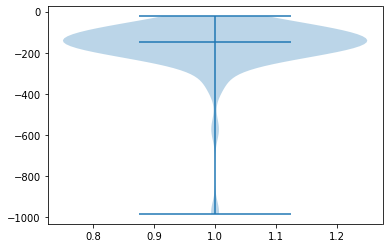

In [30]:
plt.violinplot(max_spike_index*0.195, showextrema=True, showmedians=True)

In [26]:
rec = recs.recordings[0]
unit = rec.get_good_clusters()[0]

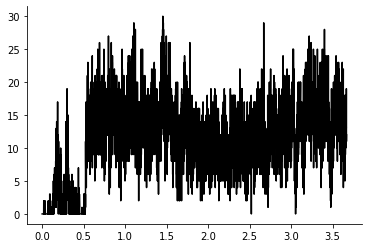

In [165]:
def plot_firing_rate(ax, gcs, ui, color='black', x_scale=1):
    fr = gcs[ui].get_firing_rate(good_units_rec[ui].rec_length)
    ax.plot(fr[0]*x_scale, fr[1], color=color)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    #ax.set_ylabel('Firing rate (Hz)')
    

fig, ax = plt.subplots(1, 1)
plot_firing_rate(ax, gcs, 43, x_scale=0.001)


In [179]:
avg_frs = [gcs[i].get_firing_rate(good_units_rec[i].rec_length)[1].mean() for i in range(len(gcs))]

{'bodies': [<matplotlib.collections.PolyCollection at 0x7f5229092a90>],
 'cmaxes': <matplotlib.collections.LineCollection at 0x7f5229092a58>,
 'cmins': <matplotlib.collections.LineCollection at 0x7f5229092d68>,
 'cbars': <matplotlib.collections.LineCollection at 0x7f5229092f60>}

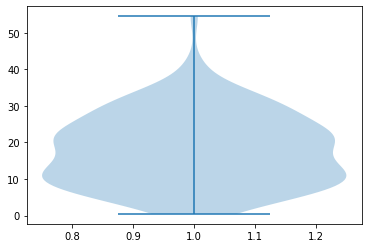

In [40]:
plt.violinplot(avg_frs)

In [27]:
fr = unit.get_firing_rate(rec.rec_length)

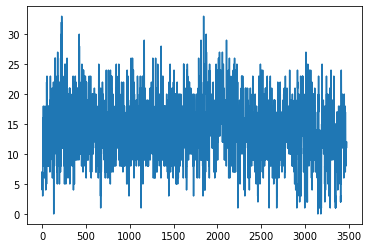

In [30]:
plt.plot(fr[0], fr[1])

In [79]:
unit = recs.recordings[0].get_good_clusters()[0]

In [81]:
print()

(82, 32)


In [63]:
print(sample_wfs.shape)


(92, 100, 90, 32)


In [31]:
lens = [len(i) for i in sample_wfs]
print(np.unique(lens))


[101 102]
